# ***In this file Pauls Model is evaluated on Vienna data***

In [1]:
#pip install h5py nibabel pandas glob2 regex
import os
import sys
import numpy as np
import nibabel as nib
import h5py
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn
os.environ["CUDA_VISIBLE_DEVICES"]= '2' #, this way I would choose GPU 3 to do the work
import scipy.io as sio

def zero_fill(arr, target_len):
    pad_width = target_len - arr.shape[-1]
    return np.pad(arr, ((0, 0), (0, pad_width)), mode='constant')

exp = 'EXP_3p4'
model_dir = os.path.abspath(f'../models/{exp}')
src_dir   = os.path.join(model_dir, 'src')
sys.path.insert(0, model_dir)
sys.path.insert(0, src_dir)

In [2]:
Vol = 5
## Load spectra
spectra = np.zeros((64,64,35,960))*1J # zero fill to match model training shape
spectra[:,:,:,:840] = np.load(f'../data/Vol{Vol}/OriginalData/data.npy')
spectra = np.fft.fftshift(np.fft.fft(spectra, axis=-1), axes=-1)

brainmask = np.load(f'../data/Vol{Vol}/masks/brain_mask.npy')
skmask = np.load(f'../data/Vol{Vol}/masks/lipid_mask.npy')
headmask = brainmask + skmask

# — flatten to (Nvox, T)
T       = spectra.shape[-1]            # 960
Data_rf = spectra.reshape(-1, T)       # (64*64*35, 960)
lipid_rf = Data_rf[skmask.flatten() > 0, :]  # only the scalp voxels

# — iterative search for β to hit your diagonal‐mean target
beta      = 1e-5 * 3
multBeta  = 1.5
target    = 0.995
lower     = None
tol       = 5e-3

while True:
    # compute the “removal” operator
    M     = lipid_rf.conj().T @ lipid_rf           # (960×960)
    RemOP = np.linalg.inv(np.eye(T) + beta * M)    # (960×960)
    fac   = np.mean(np.abs(np.diag(RemOP)))        # current diag‐mean

    if abs(fac - target) <= tol:
        break

    # adjust β up or down
    if fac < target:
        beta /= multBeta
        if lower is False:
            multBeta *= 0.5
        lower = True
    else:
        beta *= multBeta
        if lower is True:
            multBeta *= 0.5
        lower = False

# — final operators
LipidRem_Operator_ff  = RemOP
LipidProj_Operator_ff = np.eye(T) - LipidRem_Operator_ff

print(f"Achieved diag‐mean = {fac:.4f} at β = {beta:.2e}")

Achieved diag‐mean = 0.9909 at β = 9.02e-09


In [3]:
import os
import sys
import time

import numpy as np
import torch

eps = 1e-8  # Small epsilon to avoid division by zero

def runNNLipRemoval2(device, exp, spectra, LipidProj_Operator_ff, headmask, batch_size=200):
    """
    Run your trained yModel to remove lipids from `spectra`.

    Args:
        device: torch.device
        exp:    str, name of your experiment folder under ../models/
        spectra: np.ndarray, shape (X,Y,Z,T), complex after fft+fftshift
        LipidProj_Operator_ff: np.ndarray, shape (T,T), lipid‐projection operator
        headmask: np.ndarray, shape (X,Y,Z), boolean or 0/1 mask for voxels
        batch_size: int, inference batch size
    Returns:
        out_vol: np.ndarray, shape (X,Y,Z,T), lipid‐removed spectra
    """
    t0 = time.time()
    X, Y, Z, T = spectra.shape
    Nvox = X * Y * Z

    # — Flatten and select mask voxels
    S_flat    = spectra.reshape(Nvox, T)                  # (Nvox, T)
    mask_flat = (headmask.flatten() > 0)                  # (Nvox,)
    selected  = np.where(mask_flat)[0]                    # indices of voxels to process

    lip_arr      = S_flat[selected, :]                    # (Nsel, T)
    lipProj_arr  = lip_arr.dot(LipidProj_Operator_ff)     # (Nsel, T)

    # — Convert to torch complex tensors on device
    lip_t     = torch.tensor(lip_arr,     dtype=torch.cfloat, device=device)
    lipProj_t = torch.tensor(lipProj_arr, dtype=torch.cfloat, device=device)

    # — Filter out any rows with NaNs
    valid_mask = (~torch.isnan(lip_t).any(dim=1) &
                  ~torch.isnan(lipProj_t).any(dim=1))
    lip_t     = lip_t[valid_mask]
    lipProj_t = lipProj_t[valid_mask]
    valid_idx = np.where(valid_mask.cpu().numpy())[0]    # indices into `selected`

    # — Dynamically import your model code, just like in your original
    for sub in os.listdir(f'../models/{exp}'):
        if sub.startswith("src"):
            sys.path.insert(0, os.path.abspath(f'../models/{exp}'))
            sys.path.insert(0, os.path.abspath(f'../models/{exp}/{sub}'))
            from config    import params
            from src.model import yModel
            break

    # — Instantiate and load your trained yModel
    model = yModel(nLayers    = params["nLayers"],
                   nFilters   = params["nFilters"],
                   dropout    = 0,
                   in_channels  = params["in_channels"],
                   out_channels = params["out_channels"])
    params["path_to_model"] = f"../models/{exp}/"
    ckpt = torch.load(params["path_to_model"] + 'model_last.pt',
                      map_location=device)
    model.load_state_dict(ckpt)
    model.to(device).eval()

    # — Compute per-voxel energy normalization factor
    energy = torch.sqrt(torch.sum((lip_t - lipProj_t).abs()**2, dim=1) + eps)[:, None]
    energy = torch.clamp(energy, min=1e-3)

    # — Normalize and pack real/imag into channels (Nsel, 2, T)
    lip_norm     = lip_t     / energy
    lipProj_norm = lipProj_t / energy
    lip_in     = torch.stack((lip_norm.real,     lip_norm.imag),     dim=1)
    lipProj_in = torch.stack((lipProj_norm.real, lipProj_norm.imag), dim=1)

    # — Inference in batches
    Nsel = lip_t.shape[0]
    preds = torch.zeros((Nsel, 2, T), dtype=torch.float64, device='cpu')
    with torch.no_grad():
        for i in range(0, Nsel, batch_size):
            lb = lip_in[i:i+batch_size].to(device)
            lp = lipProj_in[i:i+batch_size].to(device)
            out = model(lb, lp)[:, :2, :].cpu()
            preds[i:i+batch_size] = out

    # — Reconstruct complex prediction & scale back
    pred_c = preds[:,0,:] + 1j * preds[:,1,:]   # (Nsel, T)
    pred_c = pred_c * energy.cpu()              # broadcast (Nsel,1) × (Nsel,T)

    # — Subtract predicted lipid from original
    removed = lip_t.cpu() - pred_c              # (Nsel, T)

    # — Scatter back into full volume
    full = np.zeros((Nvox, T), dtype=np.complex128)
    full_indices = selected[valid_idx]           # true flat indices in [0..Nvox)
    full[full_indices, :] = removed.numpy()
    out_vol = full.reshape(X, Y, Z, T)

    print(f"[runNNLipRemoval2] done in {time.time()-t0:.1f}s")
    return out_vol


# ——————————— Example usage ———————————
if __name__ == "__main__":
    # 1) Prepare device & experiment name
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    exp    = 'EXP_3p4'

    # 2) Load & preprocess your data
    spectra = np.zeros((64,64,35,960), dtype=np.complex128)
    spectra[:,:,:,:840] = np.load(f'../data/Vol{Vol}/OriginalData/data.npy')
    spectra = np.fft.fftshift(np.fft.fft(spectra, axis=-1), axes=-1)

    brainmask = np.load(f'../data/Vol{Vol}/masks/brain_mask.npy')
    skmask    = np.load(f'../data/Vol{Vol}/masks/lipid_mask.npy')
    headmask  = brainmask + skmask

    # 3) Compute your LipidProj_Operator_ff exactly as before
    #    (e.g. iterative β search, then LipidProj = I - RemOP)
    #    and store it in `LipidProj_Operator_ff`.
    # LipidProj_Operator_ff = ...

    # 4) Run lipid removal
    Data_LipidRemoved_rrrf = runNNLipRemoval2(
        device,
        exp,
        spectra,
        LipidProj_Operator_ff,
        headmask,
        batch_size=200
    )

    # Now `Data_LipidRemoved_rrrf` is your (64,64,35,960) lipid-removed volume.





[runNNLipRemoval2] done in 54.2s


In [4]:
Prediction_time = np.fft.ifft(np.fft.ifftshift(Data_LipidRemoved_rrrf, axes=-1), axis=-1)[:,:,:,:840]
#Prediction_time_transposed  = Prediction_time.transpose(3, 2, 0, 1)
#Prediction_time = np.swapaxes(Prediction_time, 0,1)
print(Prediction_time.shape)
#sio.savemat(f'PaulsPredictions_Vol{Vol}.mat', {'Data': Prediction_time})

(64, 64, 35, 840)


(64, 64, 35, 840)


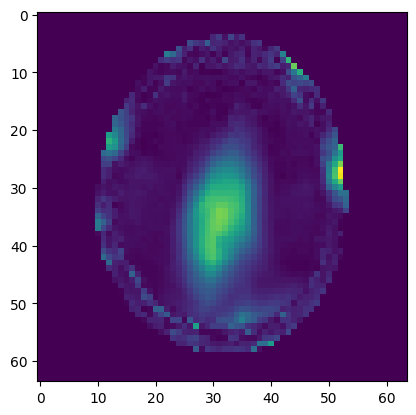

In [5]:
# Path to your file
file_path = f'../data/Vol{Vol}/OriginalData/IsolatedWater.npy'

# Open the file in read mode
water = np.load(file_path)

z,t = 17, 5

Slice = np.abs(water)[:,:,z,t]

plt.imshow(Slice)

combined = Prediction_time + water

combined_swapped = np.swapaxes(combined, 0,1)

print(combined_swapped.shape)
sio.savemat(f'PaulsPredictions_Vol{Vol}_withWater.mat', {'Data': combined_swapped})

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Start = 500
x, y = 30, 30

# Create subplots: 10 rows, 2 columns
fig, axes = plt.subplots(10, 2, figsize=(8, 20), sharex=True, sharey=True)

for idx, z in enumerate(range(5, 25)):
    row, col = divmod(idx, 2)
    ax = axes[row, col]
    
    # extract magnitude spectra from Start onward
    slice_removed = np.abs(Data_LipidRemoved_rrrf)[x, y, z, Start:]
    slice_orig    = np.abs(spectra)[x, y, z, Start:]
    
    ax.plot(slice_removed, label='Lipid removed')
    ax.plot(slice_orig,    label='Original', alpha=0.7)
    ax.set_title(f'z = {z}')
    
    # only show legend on the first subplot
    if idx == 0:
        ax.legend(loc='upper right', fontsize='small')

fig.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Start = 0
x, y = 30, 30

# No shared axes → each subplot gets its own scale
fig, axes = plt.subplots(10, 2, figsize=(8, 20))

for idx, z in enumerate(range(5, 25)):
    row, col = divmod(idx, 2)
    ax = axes[row, col]
    
    # extract magnitude spectra from Start onward
    slice_removed = np.abs(Data_LipidRemoved_rrrf)[x, y, z, Start:]
    slice_orig    = np.abs(spectra)[x, y, z, Start:]
    
    ax.plot(slice_removed, label='Lipid removed')
    ax.set_title(f'z = {z}')
    
    # autoscale in case you manually set limits elsewhere
    ax.relim()
    ax.autoscale_view()

    if idx == 0:
        ax.legend(loc='upper right', fontsize='small')

fig.tight_layout()
plt.show()



In [ ]:
zdim=20
ydim=26

sum_img_grid = np.sum(np.abs(Data_LipidRemoved_rrrf), axis=-1)



plt.imshow(sum_img_grid[:,:,zdim], cmap="gray")
x = [ydim, ydim]
y = [0,63]
plt.plot(x,y,'red')
plt.show()
plt.imshow(np.flip(np.rot90(sum_img_grid[:,ydim,:], k=3), axis=1), cmap="gray")
x = [0,63]
y = [zdim, zdim]
plt.plot(x,y,'red')
plt.show()



fig, ax = plt.subplots(nrows=20, ncols=3, figsize=(20,60), sharey=True)
for i in range(20):
    for ii in range(3):
        sl = i*3 + ii
        metab_energy = np.sqrt(np.sum(np.abs(metab_rrrf[sl,ydim,zdim,:])**2))
        if metab_energy <0.25:
            metab_energy=0.25
        metab_max = np.amax(np.abs(metab_rrrf[sl,ydim,zdim,:]))
        if metab_max <0.001:
            metab_max=0.001
        spectra_energy = spectra_energy_rrr[sl,ydim,zdim]
        norm = metab_energy#/spectra_energy
        
        spec1 = Data_LipidRemoved_rrrf[sl,ydim,zdim,:]/norm#/spectra_energy_rrr[sl,ydim,zdim]
        spec3 = metab_rrrf[sl,ydim,zdim,:]/norm#/spectra_energy_rrr[sl,ydim,zdim]
        ax[i,ii].plot(np.abs(spec3), label='metab', color='red')
        ax[i,ii].plot(np.abs(spec1), label='diff', color='orange')
        ax[i,ii].set_ylim([0,1])
        ax[i,ii].legend()
        
        ax2 = ax[i,ii].twinx()
        
        spec1 = Data_Lipid_rrrf[sl,ydim,zdim,:]
        spec3 = nuisance_rrrf[sl,ydim,zdim,:]
        ax2.plot(np.abs(spec3), label='nuisance', color='blue')
        ax2.plot(np.abs(spec1), label='pred_nuisance', color='green')
        #ax2.set_ylim([0,600])
        #ax2.legend()
        
        
        norm = (metab_energy/spectra_energy)**2
        ax[i,ii].title.set_text('LOSS: ' + str(loss_rrr[sl,ydim,zdim]/norm))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
fig.tight_layout()
#plt.savefig("images/"+exp+'_DS'+ver)
plt.show()